# Forecasting Apple Stock Prices using Multiple Models
# Author: Akhila Atmakuru

In [12]:
# =============================
# Importing Required Libraries
# =============================

# Data handling and numerical computation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Yahoo Finance for fetching historical stock price data
import yfinance as yf

# Statistical modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Error metrics for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning: LSTM model using Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Deep Learning: PyTorch 
import torch
import torch.nn as nn

# Facebook Prophet for time series forecasting
from prophet import Prophet

### Visualising Apple Stock price

[*********************100%***********************]  1 of 1 completed


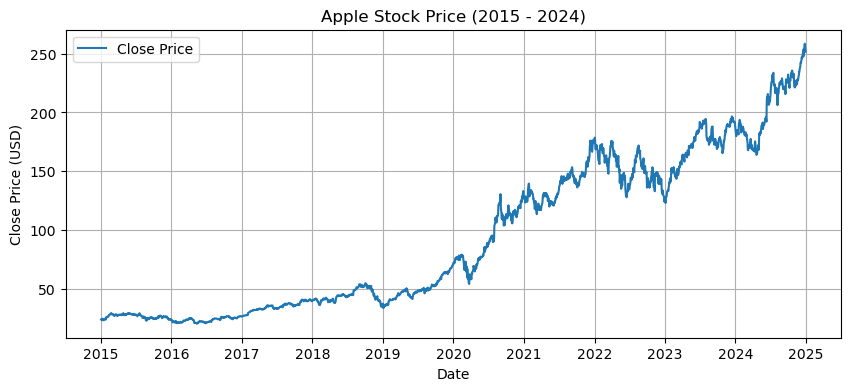

In [13]:
# =============================
# Downloading and Visualising Apple Stock Price
# =============================

# Download historical daily data for Apple Inc. from Yahoo Finance
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')

# Select only the 'Close' price for analysis
data = data[['Close']]
data.dropna(inplace=True)

# Plot the closing price over time
plt.figure(figsize=(10, 4))
plt.plot(data, label='Close Price')
plt.title("Apple Stock Price (2015 - 2024)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

# Model 01: ARIMA

ADF Statistic: 0.8448
p-value: 0.9923
Series is non-stationary. Differencing needed.


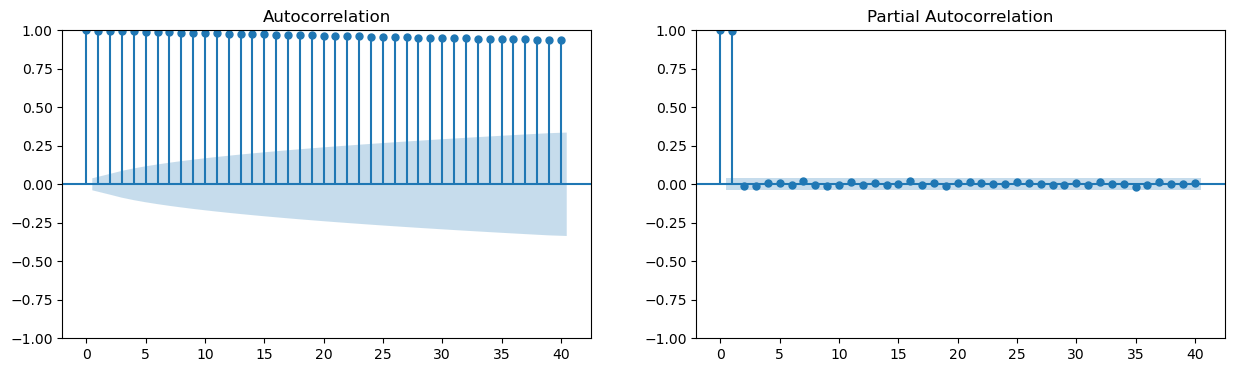

/Users/Akhila/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Akhila/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Akhila/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Akhila/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

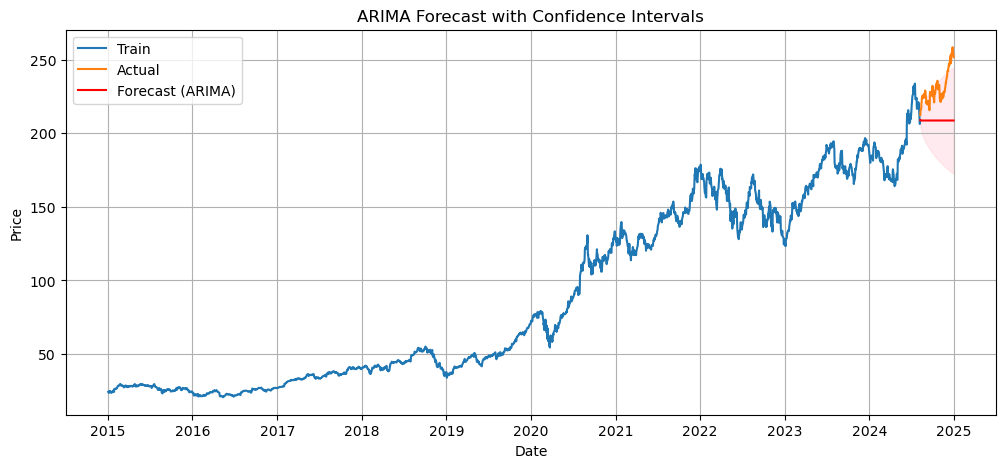

MAE: 21.85
MSE: 585.94
RMSE: 24.21


In [3]:
# =============================
# Model 01: ARIMA
# =============================

# Step 1: Test for stationarity using Augmented Dickey-Fuller (ADF) test
result = adfuller(data['Close'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
if result[1] > 0.05:
    print("Series is non-stationary. Differencing needed.")
else:
    print("Series is stationary.")

# Step 2: Plot ACF and PACF to identify ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(data['Close'], ax=axes[0], lags=40)
plot_pacf(data['Close'], ax=axes[1], lags=40)
plt.show()

# Step 3: Train-test split (last 100 observations for testing)
train = data[:-100]
test = data[-100:]

# Step 4: Fit ARIMA model
# Note: (p,d,q) = (5,1,0) here — tuned based on ACF/PACF analysis
model = ARIMA(train['Close'], order=(5, 1, 0))
model_fit = model.fit()

# Step 5: Forecast future values (100 steps ahead)
forecast_result = model_fit.get_forecast(steps=100)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
forecast.index = test.index  # Aligning forecast index with test data

# Step 6: Visualise forecast vs actual with confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast (ARIMA)', color='red')
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title("ARIMA Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Evaluate model performance
arima_mae = mean_absolute_error(test, forecast)
arima_mse = mean_squared_error(test, forecast)
arima_rmse = np.sqrt(arima_mse)

print(f'MAE: {arima_mae:.2f}')
print(f'MSE: {arima_mse:.2f}')
print(f'RMSE: {arima_rmse:.2f}')

# LSTM

Epoch 1/5


2025-05-18 16:19:41.371049: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


74/74 - 161s - loss: 0.0232 - 161s/epoch - 2s/step
Epoch 2/5
74/74 - 160s - loss: 5.0841e-04 - 160s/epoch - 2s/step
Epoch 3/5
74/74 - 156s - loss: 2.8704e-04 - 156s/epoch - 2s/step
Epoch 4/5
74/74 - 156s - loss: 2.7237e-04 - 156s/epoch - 2s/step
Epoch 5/5
74/74 - 156s - loss: 2.5082e-04 - 156s/epoch - 2s/step
4/4 [==============================] - 1s 125ms/step
Test MAE: 4.6346
Test MSE: 30.0137
Test RMSE: 5.4785


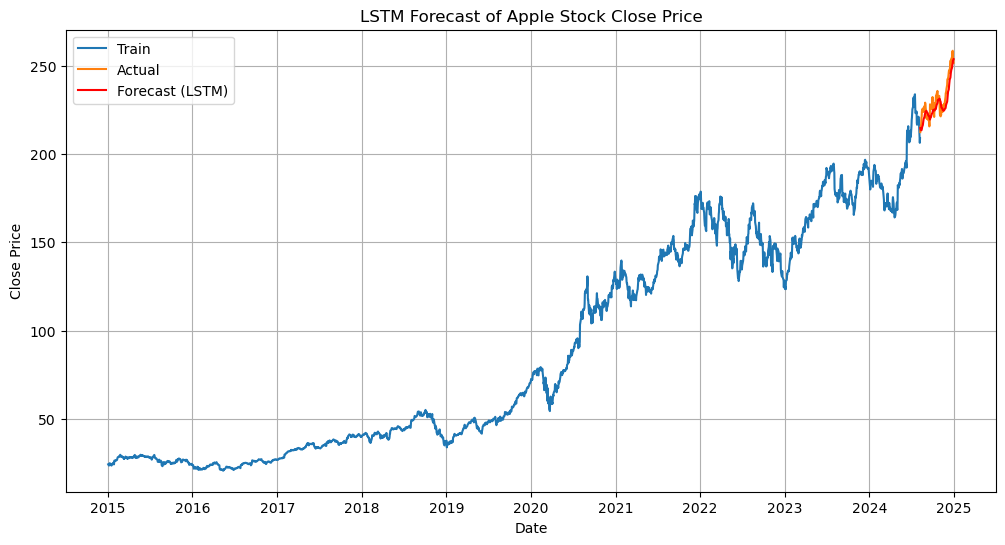

In [4]:
# =============================
# Model 02: LSTM (Long Short-Term Memory)
# =============================

# Step 1: Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 2: Prepare sequences for LSTM input
def create_sequences(dataset, seq_length=50):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i + seq_length, 0])
        y.append(dataset[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Step 3: Train-test split (last 100 samples for testing)
split = len(X) - 100
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 4: Reshape input data to [samples, timesteps, features] format for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 5: Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 6: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=2)

# Step 7: Forecast using the test set
y_pred = model.predict(X_test)

# Step 8: Inverse transform predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Step 9: Evaluate model performance
lstm_mse = mean_squared_error(y_test_inv, y_pred_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test MAE: {lstm_mae:.4f}")
print(f"Test MSE: {lstm_mse:.4f}")
print(f"Test RMSE: {lstm_rmse:.4f}")

# Step 10: Visualise actual vs forecasted prices
train_dates = data.index[:split + seq_length]
test_dates = data.index[split + seq_length:]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, data['Close'][:split + seq_length], label='Train')
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_inv, label='Forecast (LSTM)', color='red')
plt.title('LSTM Forecast of Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Transformer

/Users/Akhila/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.112340
Epoch 2/20, Loss: 0.360152
Epoch 3/20, Loss: 0.056948
Epoch 4/20, Loss: 0.134689
Epoch 5/20, Loss: 0.185004
Epoch 6/20, Loss: 0.082620
Epoch 7/20, Loss: 0.018857
Epoch 8/20, Loss: 0.047853
Epoch 9/20, Loss: 0.091306
Epoch 10/20, Loss: 0.075223
Epoch 11/20, Loss: 0.034202
Epoch 12/20, Loss: 0.010847
Epoch 13/20, Loss: 0.022522
Epoch 14/20, Loss: 0.045227
Epoch 15/20, Loss: 0.049151
Epoch 16/20, Loss: 0.031522
Epoch 17/20, Loss: 0.014203
Epoch 18/20, Loss: 0.010207
Epoch 19/20, Loss: 0.020709
Epoch 20/20, Loss: 0.030403
Test MAE: 18.4943
Test MSE: 520.5208
Test RMSE: 22.8149


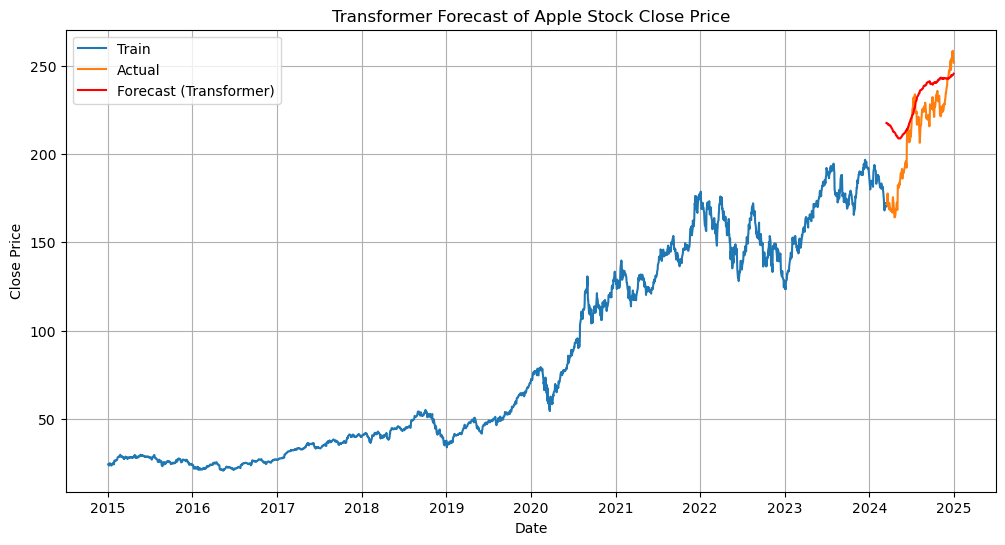

In [14]:
# =============================
# Model 03: Transformer
# =============================

# Step 1: Sequence generation function (same as LSTM)
def create_sequences(dataset, seq_length=50):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i + seq_length, 0])
        y.append(dataset[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Step 2: Train-test split
split = len(X) - 200
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 3: Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # [batch, seq_len, feature]
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Step 4: Define Transformer model architecture
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, dropout=0.1, nhead=4, d_model=64, dim_feedforward=128):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        self.input_linear = nn.Linear(feature_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src = self.input_linear(src) + self.positional_encoding
        src = src.permute(1, 0, 2)  # [seq_len, batch, features]
        output = self.transformer_encoder(src)
        output = output[-1, :, :]  # Take the last time step
        output = self.decoder(output)
        return output.squeeze()

# Step 5: Instantiate model, define loss and optimiser
model = TimeSeriesTransformer()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 6: Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Step 7: Forecasting
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Step 8: Inverse scale predictions and ground truth
y_test_inv = scaler.inverse_transform(y_test.unsqueeze(1).numpy())
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Step 9: Evaluate model performance
transformer_mae = mean_absolute_error(y_test_inv, y_pred_inv)
transformer_mse = mean_squared_error(y_test_inv, y_pred_inv)
transformer_rmse = np.sqrt(transformer_mse)
print(f"Test MAE: {transformer_mae:.4f}")
print(f"Test MSE: {transformer_mse:.4f}")
print(f"Test RMSE: {transformer_rmse:.4f}")

# Step 10: Visualise results
train_dates = data.index[:split + seq_length]
test_dates = data.index[split + seq_length:]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, data['Close'][:split + seq_length], label='Train')
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_inv, label='Forecast (Transformer)', color='red')
plt.title('Transformer Forecast of Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Prophet algorithm by Facebook

[*********************100%***********************]  1 of 1 completed
16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:18 - cmdstanpy - INFO - Chain [1] done processing


Test MSE: 335.8131
Test RMSE: 18.3252


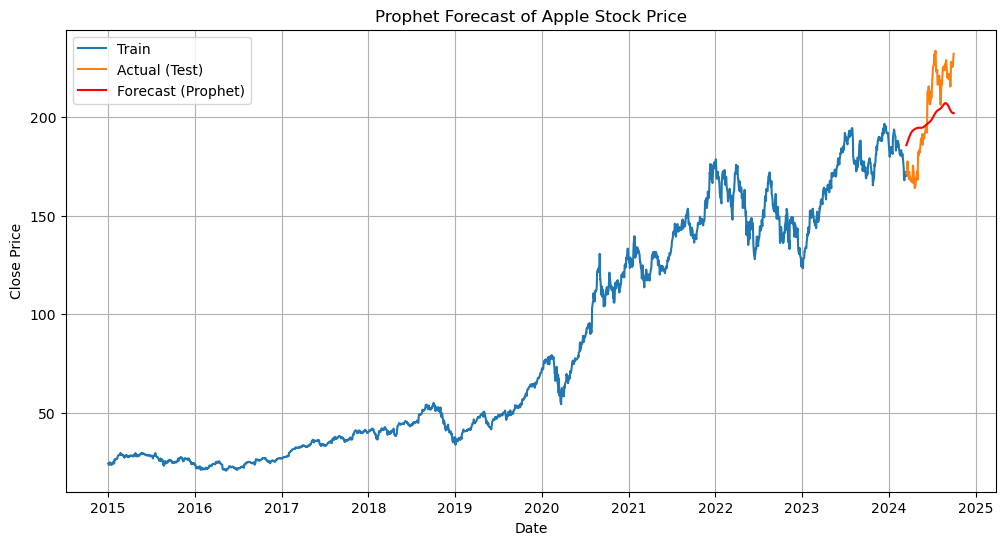

In [6]:
# =============================
# Model 04: Facebook Prophet
# =============================

# Step 1: Download and format Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2024-12-31")[['Close']].reset_index()

# Step 1: Reset index if needed (e.g., date might be index)
#data = data.reset_index()

# Flatten columns
data.columns = ['_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col for col in data.columns.values]

# Prophet requires columns named 'ds' for date and 'y' for the target variable
data = data.rename(columns={'Date': 'ds', 'Close_AAPL': 'y'})

# Confirm types
data['ds'] = pd.to_datetime(data['ds'])
data['y'] = data['y'].astype(float)

# Step 2: Train-test split (last 200 days as test)
train = data.iloc[:-200].copy()
test = data.iloc[-200:].copy()

# Step 3: Fit Prophet model
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.1)
model.fit(train)

# Step 4: Forecast into the future
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

# Step 5: Merge actual test data with forecasted values
merged = test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds', how='left').dropna(subset=['yhat'])

# Step 6: Evaluate performance
prophet_mse = mean_squared_error(merged['y'], merged['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(merged['y'], merged['yhat'])
print(f'Test MSE: {prophet_mse:.4f}')
print(f'Test RMSE: {prophet_rmse:.4f}')

# Step 7: Visualise forecast
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(merged['ds'], merged['y'], label='Actual (Test)')
plt.plot(merged['ds'], merged['yhat'], label='Forecast (Prophet)', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Forecast of Apple Stock Price')
plt.legend()
plt.grid(True)
plt.show()

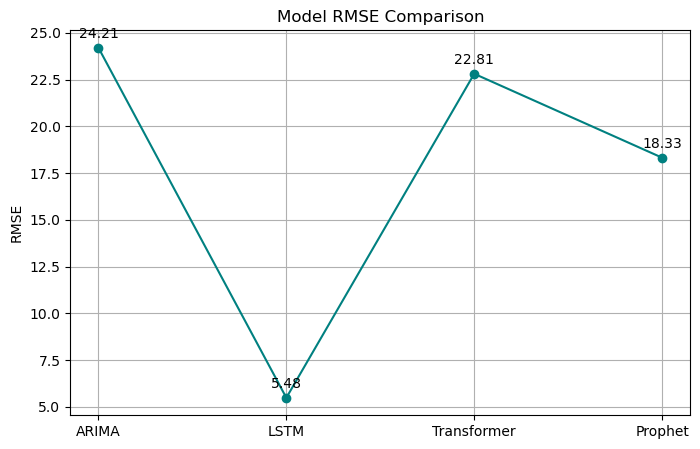

In [15]:
import matplotlib.pyplot as plt

models = ['ARIMA', 'LSTM', 'Transformer','Prophet']
rmse_values = [arima_rmse, lstm_rmse, transformer_rmse, prophet_rmse]

plt.figure(figsize=(8, 5))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='teal')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.grid(True)
for i, val in enumerate(rmse_values):
    plt.text(i, val + 0.5, f'{val:.2f}', ha='center')
plt.show()


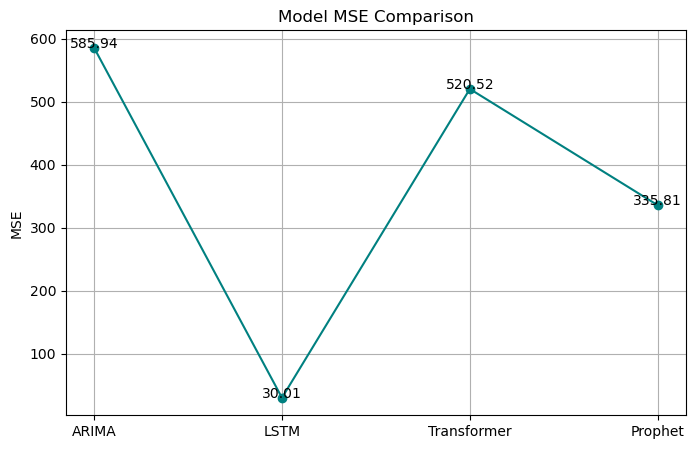

In [16]:
import matplotlib.pyplot as plt

models = ['ARIMA', 'LSTM', 'Transformer','Prophet']
mse_values = [arima_mse, lstm_mse, transformer_mse, prophet_mse]

plt.figure(figsize=(8, 5))
plt.plot(models, mse_values, marker='o', linestyle='-', color='teal')
plt.title('Model MSE Comparison')
plt.ylabel('MSE')
plt.grid(True)
for i, val in enumerate(mse_values):
    plt.text(i, val + 0.5, f'{val:.2f}', ha='center')
plt.show()


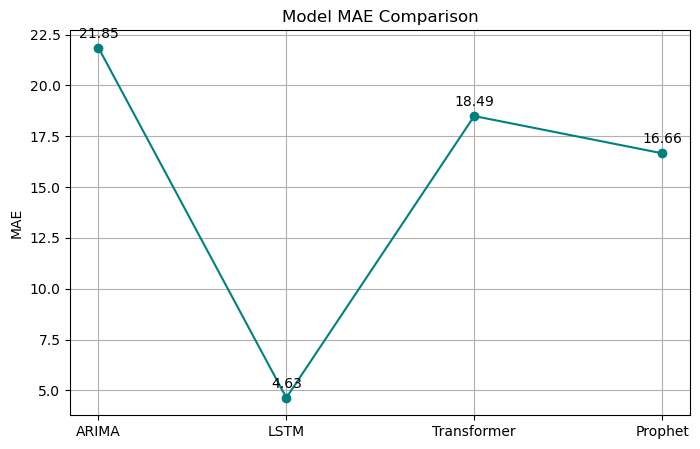

In [17]:
import matplotlib.pyplot as plt

models = ['ARIMA', 'LSTM', 'Transformer','Prophet']
mae_values = [arima_mae, lstm_mae, transformer_mae, prophet_mae]

plt.figure(figsize=(8, 5))
plt.plot(models, mae_values, marker='o', linestyle='-', color='teal')
plt.title('Model MAE Comparison')
plt.ylabel('MAE')
plt.grid(True)
for i, val in enumerate(mae_values):
    plt.text(i, val + 0.5, f'{val:.2f}', ha='center')
plt.show()


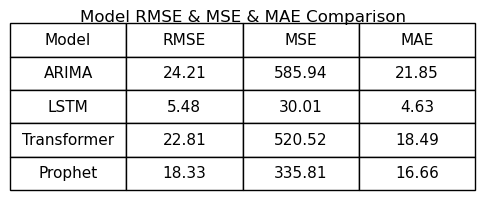

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Model': ['ARIMA', 'LSTM', 'Transformer','Prophet'],
    'RMSE': [arima_rmse, lstm_rmse, transformer_rmse, prophet_rmse],
    'MSE': [arima_mse, lstm_mse, transformer_mse, prophet_mse],
    'MAE': [arima_mae, lstm_mae, transformer_mae, prophet_mae]
}

df = pd.DataFrame(data)

# Format the DataFrame for display (without modifying the original data)
formatted_df = df.copy()
formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].applymap(lambda x: f"{x:.2f}")

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=formatted_df.values, colLabels=df.columns, loc='center', cellLoc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title('Model RMSE & MSE & MAE Comparison')
plt.show()